##### Copyright 2019 The TensorFlow Authors.

In [11]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 卷积神经网络（Convolutional Neural Network, CNN）

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/images/cnn"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/cnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://tensorflow.google.cn/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

### 导入 TensorFlow

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import scipy.io as sc
import cv2

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
mat_train = sc.loadmat('objects_potsdam_2_10_crops.mat')
train_images = np.moveaxis(mat_train['crops'], 3, 0)
train_labels = mat_train['labels']
print(train_images.shape)
print(train_labels.shape)
mat_test = sc.loadmat('objects_potsdam_2_11_crops.mat')
test_images = np.moveaxis(mat_test['crops'], 3, 0)
test_labels = mat_test['labels']
print(test_images.shape)
print(test_labels.shape)
# 将像素的值标准化至0到1的区间内。
#train_images, test_images = train_images / 255.0, test_images / 255.0

(390, 128, 128, 5)
(390, 1)
(328, 128, 128, 5)
(328, 1)


### 验证数据

我们将测试集的前 25 张图片和类名打印出来，来确保数据集被正确加载。


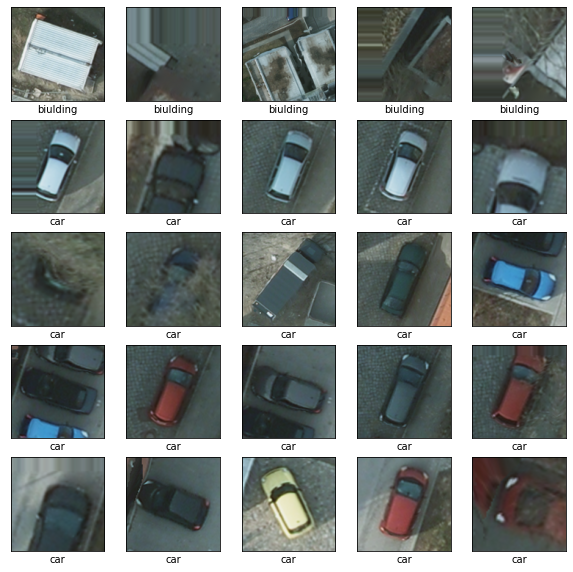

In [14]:
class_names = ['biulding', 'car', 'background']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+80,:,:,0:3], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[train_labels[i+80][0]])
plt.show()

### 构造卷积神经网络模型

下方展示的 6 行代码声明了了一个常见卷积神经网络，由几个 [Conv2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2D) 和 [MaxPooling2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/MaxPool2D) 层组成。

CNN 的输入是张量 (Tensor) 形式的 (image_height, image_width, color_channels)，包含了图像高度、宽度及颜色信息。不需要输入 batch size。如果您不熟悉图像处理，颜色信息建议您使用 RGB 色彩模式，此模式下，`color_channels` 为 `(R,G,B)` 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，CIFAR 数据集中的图片，形状是 `(32, 32, 3)`。您可以在声明第一层时将形状赋值给参数 `input_shape` 。


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 5)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation='relu'))

在上面的结构中，您可以看到每个 Conv2D 和 MaxPooling2D 层的输出都是一个三维的张量 (Tensor)，其形状描述了 (height, width, channels)。越深的层中，宽度和高度都会收缩。每个 Conv2D 层输出的通道数量 (channels) 取决于声明层时的第一个参数（如：上面代码中的 32 或 64）。这样，由于宽度和高度的收缩，您便可以（从运算的角度）增加每个 Conv2D 层输出的通道数量 (channels)。 
### 增加 Dense 层
Dense 层等同于全连接 (Full Connected) 层。
在模型的最后，您将把卷积后的输出张量（本例中形状为 (28, 28, 64)）传给一个或多个 Dense 层来完成分类。Dense 层的输入为向量（一维），但前面层的输出是3维的张量 (Tensor)。因此您需要将三维张量展开 (flatten) 到1维，之后再传入一个或多个 Dense 层。CIFAR 数据集有 3 个类，因此您最终的 Dense 层需要 3 个输出及一个 softmax 激活函数。

In [16]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))

查看完整的 CNN 结构：

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      1472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

可以看出，在被传入两个 Dense 层之前，形状为 (4, 4, 64) 的输出被展平成了形状为 (1024) 的向量。

### 编译并训练模型

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
13/13 [==============================] - 28s 697ms/step - loss: 1.1868 - accuracy: 0.3959 - val_loss: 0.8568 - val_accuracy: 0.6585
Epoch 2/10
13/13 [==============================] - 3s 255ms/step - loss: 0.7745 - accuracy: 0.7128 - val_loss: 0.5028 - val_accuracy: 0.8201
Epoch 3/10
13/13 [==============================] - 3s 253ms/step - loss: 0.3644 - accuracy: 0.8793 - val_loss: 0.6339 - val_accuracy: 0.7744
Epoch 4/10
13/13 [==============================] - 4s 284ms/step - loss: 0.3047 - accuracy: 0.9045 - val_loss: 0.5910 - val_accuracy: 0.8110
Epoch 5/10
13/13 [==============================] - 3s 262ms/step - loss: 0.3247 - accuracy: 0.8907 - val_loss: 0.4817 - val_accuracy: 0.8841
Epoch 6/10
13/13 [==============================] - 3s 260ms/step - loss: 0.2675 - accuracy: 0.8999 - val_loss: 0.4707 - val_accuracy: 0.9085
Epoch 7/10
13/13 [==============================] - 3s 256ms/step - loss: 0.2170 - accuracy: 0.9306 - val_loss: 0.3261 - val_accuracy: 0.9177
Epoch

### 评估模型

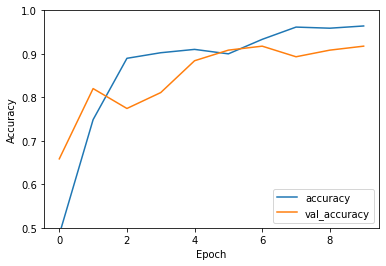

11/11 - 1s - loss: 0.2759 - accuracy: 0.9177


In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [20]:
print(test_acc)

0.917682945728302


In [21]:
# Predict a new data
img = test_images[0,:,:,:]
print(img.shape)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(128, 128, 5)
This image most likely belongs to car with a 95.57% confidence.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


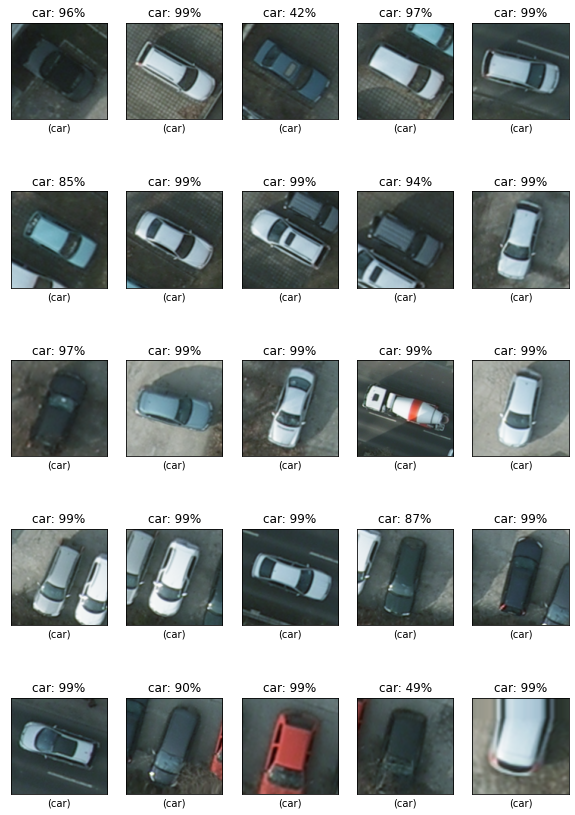

In [22]:
# Predict the first 25 test data

plt.figure(figsize=(10,15))
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i+50,:,:,0:3], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    img = test_images[i+50,:,:,:]
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    #print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    ax.title.set_text(class_names[np.argmax(score)]+': '+str(int(100 * np.max(score)))+'%')
    plt.xlabel('('+class_names[test_labels[i+50][0]]+')')
plt.show()

我们搭建的简单的 CNN 模型在测试集上可以达到 70% 的准确率。对于只有几行的代码来说效果不错！对于另一种 CNN 结构可参考另一个使用的基于 Keras 子类 API 和 `tf.GradientTape` 的样例 [here](https://tensorflow.google.cn/tutorials/quickstart/advanced)。

(6000, 6000, 3)


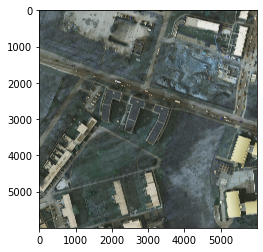

In [120]:
png_test = cv2.imread('top_potsdam_2_11_RGB.tif')
print(png_test.shape)
plt.imshow(png_test)

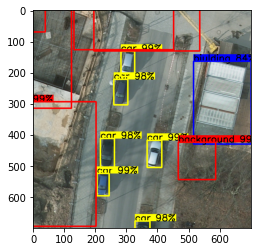

In [121]:
bb_test_mat = sc.loadmat('objects_potsdam_2_11_boundingBoxes.mat')
bbs = np.asarray(bb_test_mat['object_classes'])
bbs_0 = np.array(bbs[0][0][0][0][4]) # biulding
bbs_1 = np.array(bbs[0][1][0][0][4]) # car
bbs_2 = np.array(bbs[0][2][0][0][4]) # background
bbs = np.vstack((bbs_0,bbs_1,bbs_2))
color_dict = {'biulding': (255, 0, 0), 'car': (0, 255, 255), 'background':(0, 0, 255)}
for j in range(len(bbs)): # All images
    # Predict all the images from label[i]
    img = test_images[j,:,:,:]
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    # predicted label & percentage
    predicted_label = class_names[np.argmax(score)]
    predicted_percent = str(int(100 * np.max(score)))
    predicted_text = predicted_label+' '+predicted_percent+'%'
    
    # Calculate textsize & putText with background
    font_type, font_scale, font_color, font_thickness=cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2
    text_size, _ = cv2.getTextSize(predicted_text, font_type, font_scale, font_thickness)
    text_w, text_h = text_size
    cv2.rectangle(png_test, (bbs[j][0],bbs[j][1]), (bbs[j][0] + text_w, bbs[j][1] - text_h), color_dict[predicted_label], -1)
    cv2.putText(png_test, predicted_text,(bbs[j][0],bbs[j][1] + font_scale -1),
              font_type, font_scale, font_color, font_thickness)
    # draw boundary
    ptLeftTop = (bbs[j][0],bbs[j][1])
    ptRightBottom = (bbs[j][0]+bbs[j][2],bbs[j][1]+bbs[j][3])
    point_color = color_dict[predicted_label] # BGR
    thickness = 3
    lineType = 4
    cv2.rectangle(png_test, ptLeftTop, ptRightBottom, point_color, thickness, lineType)
cv2.imwrite('with_text.png', png_test)
plt.imshow(png_test[1600:2300,5300:6000,[2,1,0]])